**Install Transformers Library**

In [ ]:
!pip install transformers

**Import Libraries**

In [ ]:
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import time
import datetime
import random
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import transformers
from transformers import AutoModel, BertTokenizerFast
#from babel.dates import format_date, format_datetime, format_time
from tqdm import tqdm
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

# specify GPU
device = torch.device("cuda")

**Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os

os.chdir('/content/gdrive/My Drive/dataset/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df_train = pd.read_json('all_train_xlarge.json.gz', compression='gzip', lines=True)
valid = pd.read_csv('all_valid_xlarge.csv')
df_test = pd.read_json('task1_testset_1500_with_labels.json.gz', compression='gzip', lines=True)

In [ ]:
val = valid['pair_id'].tolist()
df_valid = df_train[df_train.pair_id.isin(val)]
df_valid.shape

(42947, 22)

**Check the shape of the training data**

In [ ]:
print('Original Shape of df_train : ', df_train.shape)
val = valid['pair_id'].tolist()
df_train = df_train[~df_train.pair_id.isin(val)]
print('Shape of df_train (after removal validate) : ', df_train.shape)
test = df_test['pair_id'].tolist()
df_train = df_train[~df_train.pair_id.isin(test)]
print('Shape of df_train (after removal test) : ', df_train.shape)

Original Shape of df_train :  (214661, 22)
Shape of df_train (after removal validate) :  (171714, 22)
Shape of df_train (after removal test) :  (171713, 22)


**Display the shape of the test data**

In [ ]:
df_test.shape

(1500, 21)

**Check if any product pair with lable = 1 but with different category or brand (Method1)**

In [ ]:
def check_Category_Brand(df):
  df = df.loc[df['label'] == 1 ]
  df = df.loc[df['category_left'] != df['category_right']]
  df = df.loc[df['brand_left'] != df['brand_right']]
  print(df.shape[0])
  if df.shape[0]>0:
    print(df.head())

check_Category_Brand(df_train)
check_Category_Brand(df_valid)
check_Category_Brand(df_test)

0
0
0


**Check if any product pair with lable = 1 but with different category or brand (Method2)**

In [ ]:
def check_Category_Brand2(df):
  compare_brand = np.where(df['brand_left'] == df['brand_right'], True, False)
  compare_category = np.where(df['category_left'] == df['category_right'], True, False)
  df['equal_brand'] = compare_brand
  df['equal_category'] = compare_category
  rows = df.loc[(df['label'] == 1) & (df['equal_brand'] == False) & (df['equal_category'] == False)].shape[0]
  print(rows)
  if rows>0:
    print(rows.head())


check_Category_Brand2(df_train)
check_Category_Brand2(df_valid)
check_Category_Brand2(df_test)

0
0
0


**Display the column names of the test data**

In [ ]:
df_test.columns

Index(['id_left', 'cluster_id_left', 'category_left', 'title_left',
       'description_left', 'brand_left', 'price_left', 'keyValuePairs_left',
       'specTableContent_left', 'id_right', 'cluster_id_right',
       'category_right', 'title_right', 'description_right', 'brand_right',
       'price_right', 'keyValuePairs_right', 'specTableContent_right', 'label',
       'pair_id', 'sampling', 'equal_brand', 'equal_category'],
      dtype='object')

**Import BERT-base pretrained model**

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased',return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Check the maximum length and minimum length of title & description**

In [ ]:
def get_num_tokens(column):

  l = []
  column = column.fillna('')
  l2 = column.to_list()
  tokenized_texts = tokenizer(l2)
  length = len(tokenized_texts['input_ids'])
  for i in range(length):
    l.append(len(tokenized_texts['input_ids'][i]))
  #print('No. of rows : ',len(l))
  #print('Max no. of tokens : ',max(l))
  #print('Min no. of tokens : ',min(l))
  return l


In [ ]:
from pandas import DataFrame

s1 = DataFrame (get_num_tokens(df_train['title_left']),columns=['title_left_tokens'])
s2 = DataFrame (get_num_tokens(df_train['description_left']),columns=['desc_left_tokens'])
s3 = DataFrame (get_num_tokens(df_train['title_right']),columns=['title_right_tokens'])
s4 = DataFrame (get_num_tokens(df_train['description_right']),columns=['desc_right_tokens'])

result = pd.concat([s1, s2], axis=1)
result = pd.concat([result, s3], axis=1)
result = pd.concat([result, s4], axis=1)
result['total_left_tokens'] = result['title_left_tokens']+result['desc_left_tokens']
result['total_right_tokens'] = result['title_right_tokens']+result['desc_right_tokens']

print('No. of rows : ', result.shape[0])

print('Max no. of tokens : ',result['total_left_tokens'].max())
print('Min no. of tokens : ',result['total_left_tokens'].min())

print('Max no. of tokens : ',result['total_right_tokens'].max())
print('Min no. of tokens : ',result['total_right_tokens'].min(),'\n')

result.tail()


No. of rows :  171713
Max no. of tokens :  18967
Min no. of tokens :  14
Max no. of tokens :  18967
Min no. of tokens :  14 



,title_left_tokens,desc_left_tokens,title_right_tokens,desc_right_tokens,total_left_tokens,total_right_tokens
171708,40,45,60,33,85,93
171709,31,143,28,141,174,169
171710,30,5,31,280,35,311
171711,40,202,39,2,242,41
171712,43,258,36,274,301,310


In [ ]:
result.describe()

**Remove n/a, tab & new line character**

In [ ]:
df_train['description_left'] = df_train['description_left'].fillna('')
df_train['description_right'] = df_train['description_right'].fillna('')
df_train['left_temp'] = df_train['title_left'] + df_train['description_left']
df_train['right_temp'] = df_train['title_right'] + df_train['description_right']
df_train = df_train.replace(r'\n',' ', regex=True) 
df_train = df_train.replace(r'\\n',' ', regex=True)
df_train = df_train.replace(r'\t',' ', regex=True) 
df_train = df_train.loc[:, ['left_temp', 'right_temp', 'label']]
df_train.columns = ['text_a', 'text_b', 'label']

In [ ]:
df_valid['description_left'] = df_valid['description_left'].fillna('')
df_valid['description_right'] = df_valid['description_right'].fillna('')
df_valid['left_temp'] = df_valid['title_left'] + df_valid['description_left']
df_valid['right_temp'] = df_valid['title_right'] + df_valid['description_right']
df_valid = df_valid.replace(r'\n',' ', regex=True) 
df_valid = df_valid.replace(r'\\n',' ', regex=True)
df_valid = df_valid.replace(r'\t',' ', regex=True) 
df_valid = df_valid.loc[:, ['left_temp', 'right_temp', 'label']]
df_valid.columns = ['text_a', 'text_b', 'label']

In [ ]:
df_test['description_left'] = df_test['description_left'].fillna('')
df_test['description_right'] = df_test['description_right'].fillna('')
df_test['left_temp'] = df_test['title_left'] + df_test['description_left']
df_test['right_temp'] = df_test['title_right'] + df_test['description_right']
df_test = df_test.replace(r'\n',' ', regex=True) 
df_test = df_test.replace(r'\\n',' ', regex=True)
df_test = df_test.replace(r'\t',' ', regex=True) 
df_test = df_test.loc[:, ['left_temp', 'right_temp', 'label']]
df_test.columns = ['text_a', 'text_b', 'label']

**Check class distribution**

In [ ]:
df_train.label.value_counts() / len(df_train)

0    0.859399
1    0.140601
Name: label, dtype: float64

**Save training, validation, test data as tsv for Pytorch**

In [ ]:
df_train.to_csv('train.tsv', sep='\t', index=False)
print("No. of Training Samples：", len(df_train))
df_train.head()

No. of Training Samples： 171713


,text_a,text_b,label
3,"""HP Pavilion x360 - 11-ad018ca""@en up to 2.5 ...","""HP Pavilion x360 - 11-ad018ca""@en 11-ad018ca...",1
5,"""Casio GA-201-1AER""@bg GA-201-1AER | G-Shock ...","""Reloj Casio G-Shock GA-110MB-1AER""",0
6,"""Garmin Forerunner 25 Hr Big"" Big comprar y o...","""Sandisk 16GB Cruzer Fit Usb Bellek (SDCZ33-0...",0
7,"""G-Shock Style Radio Controlled-Solar Watch""@...","""Herren Casio G-Shock Wecker Chronograf Uhr A...",0
8,"""Seagate Laptop SSHD 1 TB Internal SSHD"" "" Se...","""WD Blue 1TB 2.5"" SATA 6Gbps Solid State Driv...",0


In [ ]:
df_valid.to_csv('valid.tsv', sep='\t', index=False)
print("No. of Validate Samples：", len(df_valid))

No. of Validate Samples： 42947


In [ ]:
df_test.to_csv('test.tsv', sep='\t', index=False)
print("No. of Test Samples：", len(df_test))
df_test.head()

No. of Test Samples： 1500


,text_a,text_b,label
0,"""Intel X520-DA2 PCI Express 2.0 Network Adapt...","""Intel X520-DA2 Dual Port Gigabit SFP Etherne...",1
1,"""Zotac GeForce GTX 1070Ti AMP Extreme 8192MB ...","""Zotac NVIDIA GeForce GTX 1070 Ti 8GB AMP! Ex...",1
2,"""TP-LINK TL-WPS510U 150Mbps Wireless Print Se...","""TP-LINK TL-WPS510U - print server"" "" TP-LINK...",1
3,"""Logitech - MK550 Wireless Wave Keyboard and ...","""Logitech MK550 Wireless Wave Keyboard and Mo...",1
4,"""Western Digital - Blue 500GB 2.5"" Solid Stat...","""Buy Online | WD Blue PC SSD 500GB SATA III 2...",1


In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


**Tokenize training, validation, test data by using BERT tokenizer**

In [ ]:
# encode vs encode plus vs batch encode plus

from torch.utils.data import Dataset

class ProductDataset(Dataset):

  def __init__(self, mode, tokenizer):
    assert mode in ['train', 'valid', 'test']
    self.mode = mode
    self.df = pd.read_csv(mode + '.tsv', sep='\t').fillna('')
    self.len = len(self.df)
    self.tokenizer = tokenizer  
    self.max_len = 512
    


  def __getitem__(self, idx):
    if self.mode == "test":
      text_a, text_b = self.df.iloc[idx, :2].values
      label_tensor = None
    else:
      text_a, text_b, label = self.df.iloc[idx, :].values
      label_tensor = torch.tensor(label)

    encoded_pair = tokenizer.encode_plus(text_a, text_b, return_tensors='pt', add_special_tokens=True, max_length=self.max_len, truncation=True)
  

    tokens_tensor  = encoded_pair['input_ids'].squeeze(0)  # tensor of token ids
    segments_tensor = encoded_pair['token_type_ids'].squeeze(0)  # binary tensor with "0" for the 1st sentence tokens & "1" for the 2nd sentence tokens

    return (tokens_tensor, segments_tensor, label_tensor)
    

  def __len__(self):
    return self.len
    



trainset = ProductDataset('train', tokenizer=tokenizer)
validset = ProductDataset('valid', tokenizer=tokenizer)
testset = ProductDataset('test', tokenizer=tokenizer)

**Get length of all tokens_tensors in the train set**

In [ ]:
seq_len = [len(i[0]) for i in trainset]
pd.Series(seq_len).hist(bins = 30)

**Data Loader**

In [ ]:
# collate_fn , SequentialSampler


"""
BERT will return 4 tensors
- tokens_tensors  : (batch_size, max_seq_len_in_batch)
- segments_tensors: (batch_size, max_seq_len_in_batch)
- masks_tensors   : (batch_size, max_seq_len_in_batch)
- label_ids       : (batch_size)
"""

from torch.utils.data import DataLoader,RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
from keras.preprocessing.sequence import pad_sequences

# 'samples' which pass to this function is a list，there are 3 tensors
# - tokens_tensor
# - segments_tensor
# - label_tensor
# zero padding will be applied on token tensor & segments tensor，and generate a masks tensors
def create_mini_batch(samples):
  tokens_tensors = [s[0] for s in samples]
  segments_tensors = [s[1] for s in samples]
    
  # handling when there are labels in dataset
  if samples[0][2] is not None:
    label_ids = torch.stack([s[2] for s in samples])
  else:
    label_ids = None
    
  # zero padding
  tokens_tensors = pad_sequence(tokens_tensors,batch_first=True)
  segments_tensors = pad_sequence(segments_tensors,batch_first=True)
    
  # attention masks will set the as 1 when the tokens_tensors is not zero, BERT will only pay attention to the non-zero tokens
  masks_tensors = torch.zeros(tokens_tensors.shape,dtype=torch.long)
  masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
  return tokens_tensors, segments_tensors, masks_tensors, label_ids


# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

#define a batch size
BATCH_SIZE = 8

# sampler for sampling the data during training
train_sampler = RandomSampler(trainset)

# sampler for sampling the data during training
val_sampler = SequentialSampler(validset)

train_dataloader = DataLoader(trainset, sampler=train_sampler,batch_size=BATCH_SIZE, 
                         collate_fn=create_mini_batch)

val_dataloader = DataLoader(validset, sampler=val_sampler,batch_size=BATCH_SIZE, 
                         collate_fn=create_mini_batch)

test_dataloader = DataLoader(testset,collate_fn=create_mini_batch)


In [ ]:
'''
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False
'''

**Define Model Architecture**

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask, segments):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, mask, segments)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 2e-5) # lr 1e-3

**Compute the class weights**

In [ ]:

from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(df_train['label']), df_train['label'])

print(class_wts)

[0.58180186 3.55616535]


**Convert class weights to tensor & hyperparameter**

In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

**Function to calculate the accuracy of our predictions vs labels**

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


**Fine-Tune BERT**

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # Calculate elapsed time in minutes.
  t0 = time.time()
  # iterate over batches

  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 100 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    #sent_id, mask, labels = batch   
    sent_id, segments, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    #preds = model(sent_id, mask)
    preds = model(sent_id,mask,segments)
    features = preds[0][:,0,:].numpy()

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # Measure how long this epoch took
  elapsed = format_time(time.time() - t0)

  print("")
  print("  Average training loss: {0:.3f}".format(avg_loss))
  print("  Training epcoh took: {:}".format(elapsed))

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, elapsed, total_preds, features

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy, total_eval_accuracy = 0, 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # Calculate elapsed time in minutes.
  t0 = time.time()


  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    #sent_id, mask, labels = batch
    sent_id, segments, mask, labels = batch

    # deactivate autograd
    with torch.no_grad(): #Torch.no_Grad turns off the gradient calculation, saves memory, and speeds up the calculation (we don’t need gradient or backpropagation, because we just propagate forward
      
      # model predictions
      #preds = model(sent_id, mask)
      preds = model(sent_id,mask,segments)
      features = preds[0][:,0,:].numpy()

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()
      label_ids = labels.to('cpu').numpy()

      total_preds.append(preds)

      # Calculate the accuracy for this batch of test sentences, and
      # accumulate it over all batches.
      total_eval_accuracy += flat_accuracy(preds, label_ids)
  
  # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
  print("\n  Accuracy: {0:.2f}".format(avg_val_accuracy))

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # Measure how long this epoch took
  elapsed = format_time(time.time() - t0)

  print("  Validation Loss: {0:.3f}".format(avg_loss))
  print("  Validation took: {:}".format(elapsed))

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, elapsed, avg_val_accuracy, total_preds, features

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
training_stats = []

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, training_time, _ = train()
    
    #evaluate model
    valid_loss, validation_time, avg_val_accuracy, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    #train_losses.append(train_loss)
    #valid_losses.append(valid_loss)
    
    #print(f'\nTraining Loss: {train_loss:.3f}')
    #print(f'Validation Loss: {valid_loss:.3f}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': train_loss,
            'Valid. Loss': valid_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

In [ ]:
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.34,0.31,0.97,1:30:57,0:07:33
2,0.21,0.28,0.97,1:31:11,0:07:29
3,0.16,0.26,0.98,1:31:14,0:07:32
4,0.14,0.17,0.98,1:30:48,0:07:30
5,0.13,0.20,0.98,1:30:45,0:07:33


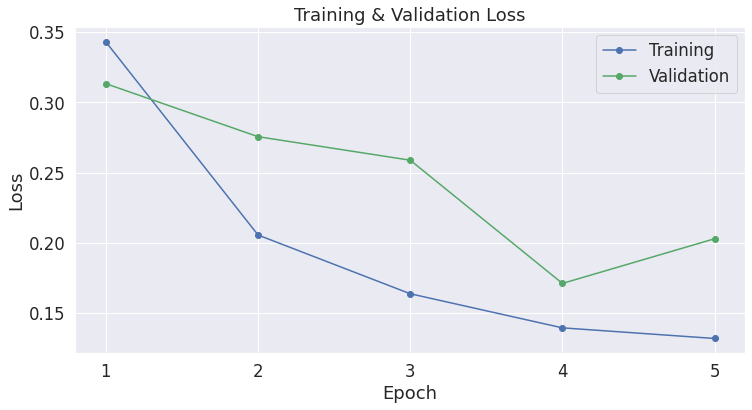

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

**Make Predictions**

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
preds_all = []

with torch.no_grad(): #Torch.no_Grad turns off the gradient calculation, saves memory, and speeds up the calculation (we don’t need gradient or backpropagation, because we just propagate forward
  for seq, attn_masks, token_type_ids, _ in test_dataloader:
    seq, attn_masks, token_type_ids = seq.to(device), attn_masks.to(device), token_type_ids.to(device)
    preds = model(seq, token_type_ids, attn_masks)
    preds = preds.detach().cpu().numpy()
    preds_all += preds.tolist()

In [ ]:
# model's performance
test_y = torch.tensor(df_test['label'].tolist())
predictions = np.argmax(preds_all, axis = 1)
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       975
           1       0.81      0.83      0.82       525

    accuracy                           0.87      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.87      0.87      0.87      1500



In [ ]:
# confusion matrix
pd.crosstab(test_y, predictions)

col_0,0,1
row_0,,
0,871,104
1,91,434
